# Импорт необходимых библиотек

In [ ]:
import numpy as np
import copy
import matplotlib.pyplot as plt
import matplotlib
import json
font = {'size'   : 10}
matplotlib.rc('font', **font)
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, SimpleRNN, GRU, LSTM, Dropout, TimeDistributed, Input
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD, RMSprop, Adam

# Загрузка набора данных

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
import sys
sys.path.append('/content/gdrive/My Drive/Colab Notebooks/10_nodes_new')
df = pd.read_csv('gdrive/My Drive/Colab Notebooks/10_nodes_new/data/10_nodes_LU.csv')
df.head()

Mounted at /content/gdrive


,"X(1, 2)","X(1, 5)","X(1, 8)","X(2, 3)","X(3, 4)","X(3, 8)","X(3, 9)","X(4, 10)","X(5, 6)","X(6, 7)",...,"Y4(3, 4)","Y4(3, 8)","Y4(3, 9)","Y4(4, 10)","Y4(5, 6)","Y4(6, 7)","Y4(6, 8)","Y4(6, 9)","Y4(7, 10)","Y4(9, 10)"
0,0.6,0.9,0.8,0.5,0.4,0.6,0.2,0.8,0.0,0.7,...,1,0,0,1,0,0,0,0,0,0
1,0.8,0.8,0.6,0.5,1.0,0.3,0.7,0.3,0.4,0.0,...,0,0,0,0,1,0,0,1,0,1
2,0.7,0.1,0.7,0.1,1.0,0.0,1.0,0.4,0.6,0.1,...,0,1,0,0,0,0,1,1,0,1
3,0.3,0.2,0.0,0.9,0.0,0.4,0.4,0.1,0.0,0.3,...,0,0,0,0,0,0,1,1,0,1
4,0.1,0.4,1.0,0.9,0.5,0.6,0.2,0.9,1.0,1.0,...,0,1,1,0,0,0,0,0,0,1


# Загрузка результатов оптимизации гиперпараметров

In [ ]:
with open('gdrive/My Drive/Colab Notebooks/10_nodes_new/analysis/All/All.json', 'r') as f1:
    data = json.load(f1)
for key in data:
    data[key] = np.array(data[key])
number_runs = 30
x = np.arange(number_runs) + 1

# Точность обучения каждого алгоритма

<ipython-input-5-b1b343c58533>:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(labels, rotation=45, ha="right")


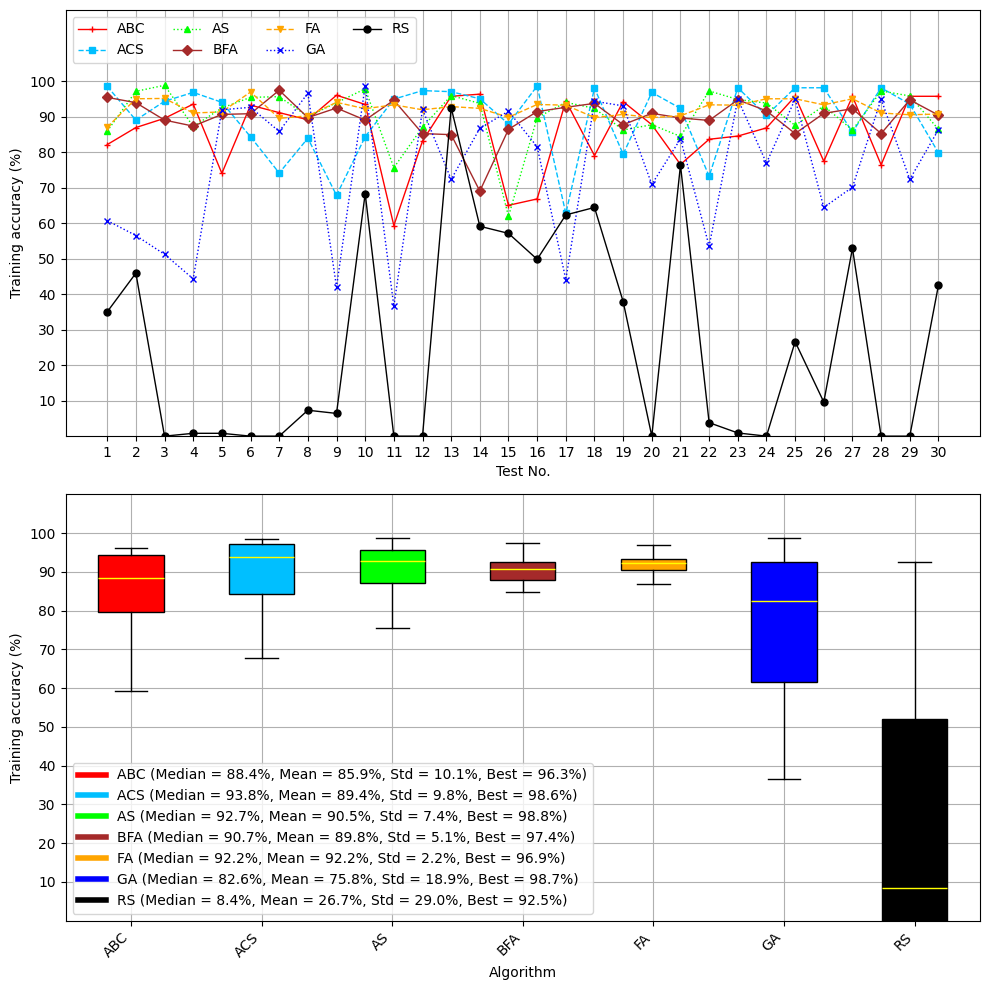

In [ ]:
metrics = ["train_ABC", "train_ACS", "train_AS", "train_BFA", "train_FA", "train_GA", "train_RS"]
labels = ["ABC", "ACS", "AS", "BFA", "FA", "GA", "RS"]
colors = ['red', 'deepskyblue', 'lime', 'brown', 'orange', 'blue', 'black']
linestyles = ['solid', 'dashed', 'dotted', 'solid', 'dashed', 'dotted', 'solid']
markers = ['+', 's', '^', 'D', 'v', 'x', 'o']

statistics = {metric: {
    'mean': round(np.mean(data[metric]), 1),
    'std': round(np.std(data[metric]), 1),
    'min': round(np.min(data[metric]), 1),
    'max': round(np.max(data[metric]), 1),
    'median': round(np.median(data[metric]), 1)
} for metric in metrics}

fig, axs = plt.subplots(2, 1, figsize=(10, 10))

ax1 = axs[0]
xticks = range(1, 31)
yticks = (np.arange(10) + 1) * 10
ax1.set_xticks(xticks, minor=False)
ax1.set_yticks(yticks, minor=False)
ax1.set_ylim(0, 120)
ax1.set_xlabel("Test No.")
ax1.set_ylabel("Training accuracy (%)")
ax1.grid()
for i, metric in enumerate(metrics):
    ax1.plot(
        x, data[metric],
        linewidth=1, color=colors[i], linestyle=linestyles[i], marker=markers[i], markersize=5
    )
ax1.legend(labels, loc="upper left", ncol=4)

ax2 = axs[1]
ax2.set_xticklabels(labels, rotation=45, ha="right")
ax2.set_yticks(yticks, minor=False)
ax2.set_ylim(0, 110)
ax2.set_xlabel("Algorithm")
ax2.set_ylabel("Training accuracy (%)")
ax2.grid()
data_for_boxplot = [data[metric] for metric in metrics]
box = ax2.boxplot(data_for_boxplot, patch_artist=True, vert=True, showfliers=False,
                  medianprops=dict(color='yellow', linewidth=1))
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

handles = [plt.Line2D([0], [0], color=color, lw=4) for color in colors]
legend_labels = [
    f"{labels[i]} (Median = {statistics[metric]['median']}%, Mean = {statistics[metric]['mean']}%, Std = {statistics[metric]['std']}%, Best = {statistics[metric]['max']}%)"
    for i, metric in enumerate(metrics)
]
plt.legend(handles, legend_labels, loc="lower left")
plt.tight_layout()
plt.savefig("/content/gdrive/My Drive/Colab Notebooks/10_nodes_new/analysis/All/Training_accuracy.png", dpi=200, bbox_inches='tight')
plt.show()

# Точность тестирования каждого алгоритма.

<ipython-input-6-1be256e7a93f>:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(labels, rotation=45, ha="right")


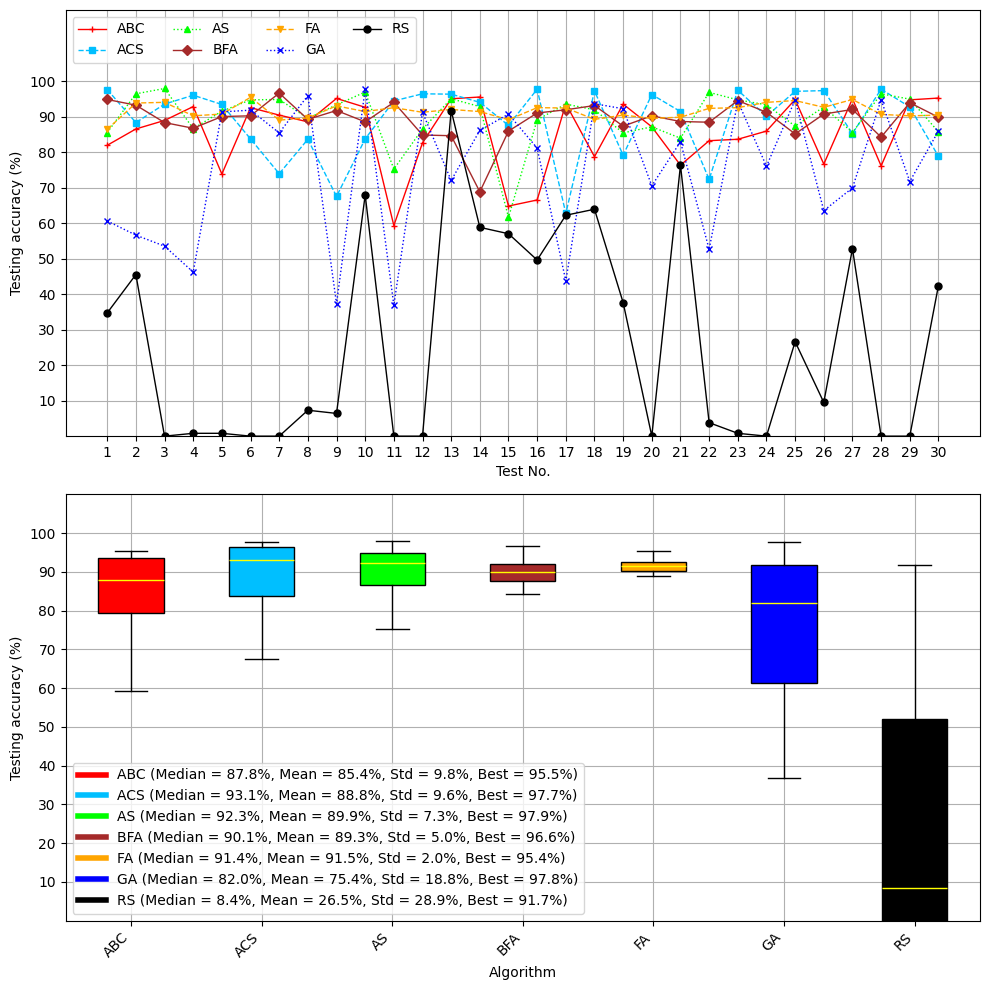

In [ ]:
metrics = ["test_ABC", "test_ACS", "test_AS", "test_BFA", "test_FA", "test_GA", "test_RS"]
labels = ["ABC", "ACS", "AS", "BFA", "FA", "GA", "RS"]
colors = ['red', 'deepskyblue', 'lime', 'brown', 'orange', 'blue', 'black']
linestyles = ['solid', 'dashed', 'dotted', 'solid', 'dashed', 'dotted', 'solid']
markers = ['+', 's', '^', 'D', 'v', 'x', 'o']

statistics = {metric: {
    'mean': round(np.mean(data[metric]), 1),
    'std': round(np.std(data[metric]), 1),
    'min': round(np.min(data[metric]), 1),
    'max': round(np.max(data[metric]), 1),
    'median': round(np.median(data[metric]), 1)
} for metric in metrics}

fig, axs = plt.subplots(2, 1, figsize=(10, 10))

ax1 = axs[0]
xticks = range(1, 31)
yticks = (np.arange(10) + 1) * 10
ax1.set_xticks(xticks, minor=False)
ax1.set_yticks(yticks, minor=False)
ax1.set_ylim(0, 120)
ax1.set_xlabel("Test No.")
ax1.set_ylabel("Testing accuracy (%)")
ax1.grid()
for i, metric in enumerate(metrics):
    ax1.plot(
        x, data[metric],
        linewidth=1, color=colors[i], linestyle=linestyles[i], marker=markers[i], markersize=5
    )
ax1.legend(labels, loc="upper left", ncol=4)

ax2 = axs[1]
ax2.set_xticklabels(labels, rotation=45, ha="right")
ax2.set_yticks(yticks, minor=False)
ax2.set_ylim(0, 110)
ax2.set_xlabel("Algorithm")
ax2.set_ylabel("Testing accuracy (%)")
ax2.grid()
data_for_boxplot = [data[metric] for metric in metrics]
box = ax2.boxplot(data_for_boxplot, patch_artist=True, vert=True, showfliers=False,
                  medianprops=dict(color='yellow', linewidth=1))
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

handles = [plt.Line2D([0], [0], color=color, lw=4) for color in colors]
legend_labels = [
    f"{labels[i]} (Median = {statistics[metric]['median']}%, Mean = {statistics[metric]['mean']}%, Std = {statistics[metric]['std']}%, Best = {statistics[metric]['max']}%)"
    for i, metric in enumerate(metrics)
]
plt.legend(handles, legend_labels, loc="lower left")
plt.tight_layout()
plt.savefig("/content/gdrive/My Drive/Colab Notebooks/10_nodes_new/analysis/All/Testing_accuracy.png", dpi=200, bbox_inches='tight')
plt.show()

# Время выполнения каждого алгоритма

<ipython-input-8-d99d59f8db4e>:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(labels, rotation=45, ha="right")


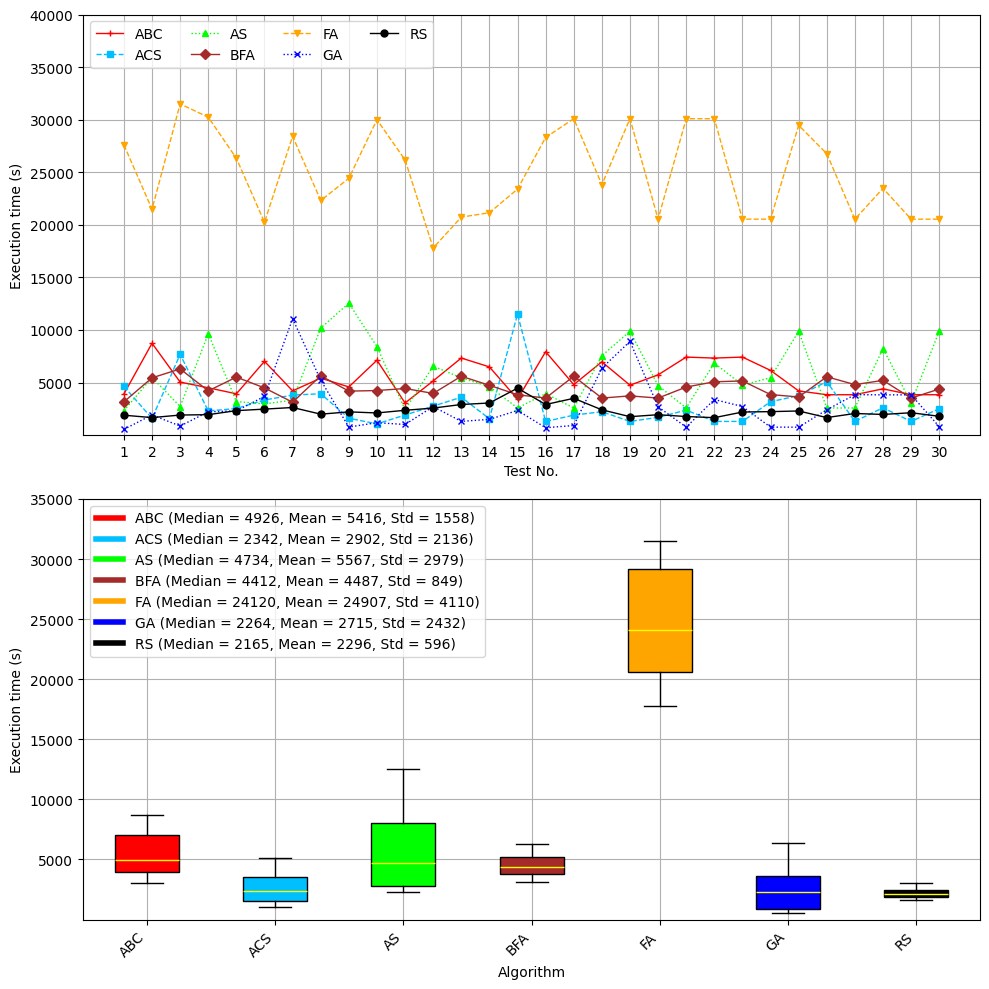

In [ ]:
metrics = ["time_ABC", "time_ACS", "time_AS", "time_BFA", "time_FA", "time_GA", "time_RS"]
labels = ["ABC", "ACS", "AS", "BFA", "FA", "GA", "RS"]
colors = ['red', 'deepskyblue', 'lime', 'brown', 'orange', 'blue', 'black']
linestyles = ['solid', 'dashed', 'dotted', 'solid', 'dashed', 'dotted', 'solid']
markers = ['+', 's', '^', 'D', 'v', 'x', 'o']

statistics = {metric: {
    'mean': round(np.mean(data[metric])),
    'std': round(np.std(data[metric])),
    'min': round(np.min(data[metric])),
    'max': round(np.max(data[metric])),
    'median': round(np.median(data[metric]))
} for metric in metrics}

fig, axs = plt.subplots(2, 1, figsize=(10, 10))

ax1 = axs[0]
xticks = range(1, 31)
yticks = (np.arange(10) + 1) * 5000
ax1.set_xticks(xticks, minor=False)
ax1.set_yticks(yticks, minor=False)
ax1.set_ylim(0, 40000)
ax1.set_xlabel("Test No.")
ax1.set_ylabel("Execution time (s)")
ax1.grid()
for i, metric in enumerate(metrics):
    ax1.plot(
        x, data[metric],
        linewidth=1, color=colors[i], linestyle=linestyles[i], marker=markers[i], markersize=5
    )
ax1.legend(labels, loc="upper left", ncol=4)

ax2 = axs[1]
ax2.set_xticklabels(labels, rotation=45, ha="right")
ax2.set_yticks(yticks, minor=False)
ax2.set_ylim(0, 35000)
ax2.set_xlabel("Algorithm")
ax2.set_ylabel("Execution time (s)")
ax2.grid()
data_for_boxplot = [data[metric] for metric in metrics]
box = ax2.boxplot(data_for_boxplot, patch_artist=True, vert=True, showfliers=False,
                  medianprops=dict(color='yellow', linewidth=1))
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

handles = [plt.Line2D([0], [0], color=color, lw=4) for color in colors]
legend_labels = [
    f"{labels[i]} (Median = {statistics[metric]['median']}, Mean = {statistics[metric]['mean']}, Std = {statistics[metric]['std']})"
    for i, metric in enumerate(metrics)
]
plt.legend(handles, legend_labels, loc="upper left")
plt.tight_layout()
plt.savefig("/content/gdrive/My Drive/Colab Notebooks/10_nodes_new/analysis/All/Time.png", dpi=200, bbox_inches='tight')
plt.show()